In [3]:
from resizeimage import resizeimage
#!pip install python-resize-image
import pandas as pd
import os, sys, glob
import math
import warnings
import PIL
import numpy as np
from PIL import Image
import cv2
import random
warnings.filterwarnings("ignore")

In [4]:
def resize(image, imageName, basewidth=600, Rootpath='/home/kevimwe/tensorflow/models/research/object_detection/CapstoneB/samples-1k/Driving_condition/snowy/'):
    path = Rootpath+"images_Resized/"
    import os, errno
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    img = Image.open(image)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
    img.save(path+imageName+ "_reSized.jpg")
    return(img.size[0],img.size[1] , imageName+ "_reSized.jpg")

In [5]:
#Main
def imageDATA(Rootpath):
    images_data = pd.DataFrame()
    image_Name =[]
    image_Original_Width =[]
    image_Original_Height =[]
    image_Scaled_Width =[]
    image_Scaled_Height =[] 
    new_filename =[] 
    #path = os.getcwd()+"/image_resizing_day/"
    path_wd = Rootpath+'images/'
    os.chdir(path_wd)
    images = glob.glob("*.jpg")
    for image in images:
        imageName = image.split('.')[0]
        X = Image.open(image).size[0]
        Y = Image.open(image).size[0]
        X_new, Y_new, Z_new = resize(image, imageName)
        image_Name =image_Name + [image]
        image_Original_Width =image_Original_Width+[Y]
        image_Original_Height = image_Original_Height+[Y]
        image_Scaled_Width =image_Scaled_Width+ [X_new]
        image_Scaled_Height =image_Scaled_Height+ [Y_new]
        new_filename =new_filename+ [Z_new]

    images_data = pd.DataFrame({'filename':image_Name ,'new_filename':new_filename  ,'width':image_Original_Width ,'height':image_Original_Height,
                                'width_scaled':image_Scaled_Width , 'height_scaled':image_Scaled_Height })  
    return(images_data)

In [6]:
def GroundTruthScaler(df2, Original_GT):
    df1 = Original_GT[Original_GT.filename.isin(list(df2.filename))] #limiting data to just the new images
    image_Scaled_Width =[]
    image_Scaled_Height =[] 
    newFilename =[]
    #Merge the two datasets
    
    f = lambda x:int(x) #into expect some rounding error
    
    for index, row in df1.iterrows():
        #print(row.filename)
        image_Scaled_Width = image_Scaled_Width + [int(df2[df2.filename==row.filename].width_scaled)]
        image_Scaled_Height = image_Scaled_Height + [int(df2[df2.filename==row.filename].height_scaled)]
        newFilename = newFilename + [str(row.filename).split('.')[0]+'_reSized.jpg']
        #print(str(row.filename).split('.'))
    df1['New_filename'] =  newFilename
    df1['widthScaled'] = image_Scaled_Width
    df1['heightScaled'] = image_Scaled_Height
    df1['Width%Scaler'] = 1+(df1.widthScaled -df1.width )/df1.width   
    df1['Height%Scaler'] = 1+(df1.heightScaled -df1.height )/df1.height
    df1['xmin_new'] = [f(x) for x in df1['xmin']*df1['Width%Scaler']]
    df1['ymin_new'] =[f(x) for x in df1['ymin']*df1['Height%Scaler']]
    df1['xmax_new'] =[f(x) for x in df1['xmax']*df1['Width%Scaler']]
    df1['ymax_new'] =[f(x) for x in df1['ymax']*df1['Height%Scaler']]
    list_ =['filename','New_filename', 'width', 'height', 'class','widthScaled', 'heightScaled','xmin', 'ymin', 'xmax', 'ymax','id', 'xmin_scaled', 'ymin_scaled', 'xmax_scaled', 'ymax_scaled', 'xmin_new', 'ymin_new','xmax_new',  'ymax_new']
    FinalDataGTScaled = df1[list_]
    FinalDataGTScaled['xmin_new_scaled'] = FinalDataGTScaled['xmin_new']/ FinalDataGTScaled['widthScaled']
    FinalDataGTScaled['ymin_new_scaled'] =FinalDataGTScaled['ymin_new']/ FinalDataGTScaled['heightScaled'] 
    FinalDataGTScaled['xmax_new_scaled'] =FinalDataGTScaled['xmax_new']/ FinalDataGTScaled['widthScaled'] 
    FinalDataGTScaled['ymax_new_scaled'] =FinalDataGTScaled['ymax_new']/ FinalDataGTScaled['heightScaled'] 
    return(FinalDataGTScaled)

In [7]:
# reference: https://github.com/datitran/raccoon_dataset/blob/master/draw%20boxes.ipynb
def draw_boxes(image_name, imagedir, GroundTruthLabels, T =1):
    
    '''
    Function draws sample bounding boxes to verify scaling on groundtruth cordinates to images
    '''
    
    if T == 1: #original Image
        GroundTruth_value = GroundTruthLabels[GroundTruthLabels.filename == image_name]
        img = cv2.imread(imagedir+image_name)
        for index, row in GroundTruth_value.iterrows():
            img = cv2.rectangle(img, (row.xmin,row.ymin),(row.xmax,row.ymax),(0, 255, 0), 3)
    else:
        GroundTruth_value = GroundTruthLabels[GroundTruthLabels.New_filename == image_name]
        img = cv2.imread(imagedir+image_name)
        for index, row in GroundTruth_value.iterrows():
            img = cv2.rectangle(img, (row.xmin_new,row.ymin_new),(row.xmax_new,row.ymax_new),(0, 255, 0), 1)
        
    return img


In [8]:
from itertools import islice
from random import randint
import math 
import random

def chunks(lst, n=2):
    '''
    Function to split image list into train, test and val
    '''
    Y = np.array_split(lst,n) #split data into two one part for training
    Train = Y[0]
    X = np.array_split(Y[1],n)
    Test = X[0]
    Validation = X[1]
    return(Train, Test, Validation)

In [9]:

def  Data_Split(newGTfile, path):
    
    '''
    Function to to split scaled data into test train and validation 
    and save them into there repective directory for transfer learning
    
    Train:  object_detection/images/train [images, train_labels.csv] 
    Test:   object_detection/images/test [images, test_labels.csv] 
    Validation: object_detection/samples-1k/[day, night, rainy, snowy]/images + ground_truth.csv
    
    '''

    image_list= pd.unique(newGTfile.New_filename) #images list
    
    Train_list, Test_list, Val_list = chunks(image_list) #split images list
    
    filter_column = ['New_filename', 'widthScaled','heightScaled', 'class', 'xmin_new',
                     'ymin_new','xmax_new', 'ymax_new', 'xmin_new_scaled', 'ymin_new_scaled',
                     'xmax_new_scaled', 'ymax_new_scaled','id']
    #filename	width	height	class	xmin	ymin	xmax	ymax
    final_name =['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'xmin_scaled',
       'ymin_scaled', 'xmax_scaled', 'ymax_scaled', 'id']
    
    FinalDataGT = newGTfile[filter_column] #filter columns
    display(FinalDataGT.head())
    FinalDataGT.columns = final_name # rename columns
    # Split Groundtruth files for transfer learning
    Train_DF = FinalDataGT[FinalDataGT.filename.isin(list(Train_list))]
    Test_DF = FinalDataGT[FinalDataGT.filename.isin(list(Test_list))]
    Val_DF = FinalDataGT[FinalDataGT.filename.isin(list(Val_list))]
    
    
    # Split desired images into folders copy to over from images_resised folder
    # Check if val, test and train 
    
    import os, errno, shutil
    try:
        #validation
        os.makedirs(path+'images/images/Val/')
        Val_DF.to_csv(path+'images/images/val_labels.csv', index=False)  
        # Test folder
        os.makedirs(path+'images/images/Test/')
        Test_DF.to_csv(path+'images/images/test_labels.csv', index=False)
        os.makedirs(path+'images/images/Train/')
        Train_DF.to_csv(path+'images/images/train_labels.csv', index=False)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
    #Copy images files over fot desired folders from Resized folder
    os.chdir(path+'/images_Resized/') #Change working directory
    for f in Val_list:
        shutil.copy(f, path+'images/images/Val/')
    for f in Test_list:
        shutil.copy(f, path+'images/images/Test/')
    for f in Train_list:
        shutil.copy(f, path+'images/images/Train/')



In [10]:
#######################
#       Main          #
#######################

def Run_ImageScaler(Rootpath ='/home/kevimwe/tensorflow/models/research/object_detection/CapstoneB/samples-1k/Driving_condition/', condition ='snowy'):
    images_data = imageDATA(Rootpath+condition+'/')
    #imageDATA('/home/kevimwe/tensorflow/models/research/object_detection/CapstoneB/samples-1k/Driving_condition/day/')

    
    os.chdir(Rootpath+condition+'/')
    day_GT = pd.read_csv(condition+"_groundTruthlabels.csv")
    #display(day_GT)

    #scaled data
    Temp2 =GroundTruthScaler(images_data, day_GT)
    

    
    GroundTruth =Temp2##pd.read_csv(File)
    imageslist  =pd.unique(GroundTruth.filename)
    #print(imageslist)
    path =Rootpath+condition+'/images/'
    path2 =Rootpath+condition+'/images_Resized/'

    i=random.randint(0, len(imageslist))

    #sample scaling
    display(Image.fromarray(draw_boxes(imageslist[i], path, GroundTruth, 1)))
    display(Image.fromarray(draw_boxes(imageslist[i].split('.')[0]+'_reSized.jpg', path2, GroundTruth, 0)))


    Temp2.to_csv(condition+"_ScaledgroundTruthlabels.csv", index=False)


    Data_Split(pd.read_csv(condition+'_ScaledgroundTruthlabels.csv'),  Rootpath+condition+'/')
    
    
    
    print("Success!!!")
    
    return(Temp2)

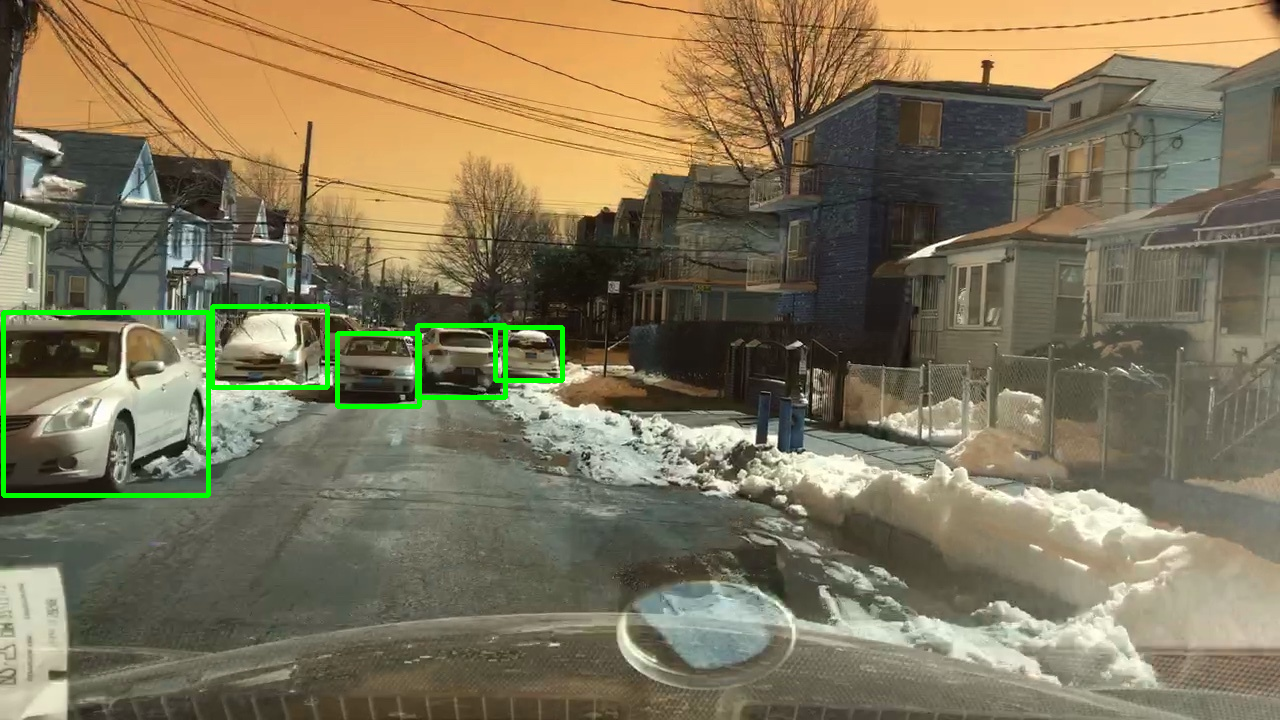

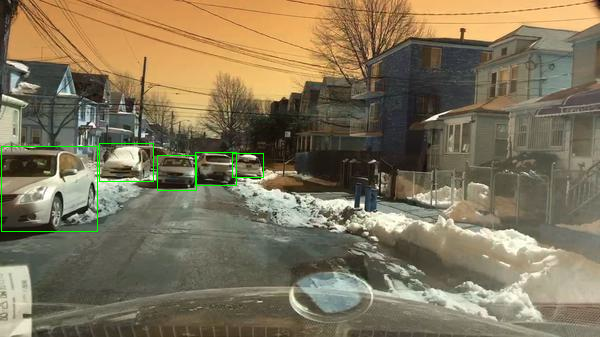

,New_filename,widthScaled,heightScaled,class,xmin_new,ymin_new,xmax_new,ymax_new,xmin_new_scaled,ymin_new_scaled,xmax_new_scaled,ymax_new_scaled,id
0,s55_reSized.jpg,600,360,car,241,223,321,290,0.401667,0.619444,0.535000,0.805556,3
1,s55_reSized.jpg,600,360,truck,340,192,411,267,0.566667,0.533333,0.685000,0.741667,8
2,s32_reSized.jpg,600,333,car,307,139,327,157,0.511667,0.417417,0.545000,0.471471,3
3,s38_reSized.jpg,600,337,car,75,214,206,295,0.125000,0.635015,0.343333,0.875371,3
4,s38_reSized.jpg,600,337,car,304,224,345,263,0.506667,0.664688,0.575000,0.780415,3


Success!!!


In [11]:

TempX =Run_ImageScaler()
